# **Seminar 5 - Генеративные нейросети, часть 1**
*Naumov Anton (Any0019)*

*To contact me in telegram: @any0019*

## 1. Сравнение распределений

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
%matplotlib inline

import torch
from torch import distributions as distrs
from torch.distributions.multivariate_normal import MultivariateNormal

from IPython.display import clear_output

from tqdm.auto import tqdm, trange

### 1.1 Создадим target

/home/denis/Documents/5_ITMO/deep-learning/deep-learning-practice/venv/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/tmp/ipykernel_182562/3533768848.py:54: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  cs.collections[-1].set_label(f"{label} contour lines")


IndexError: list index out of range

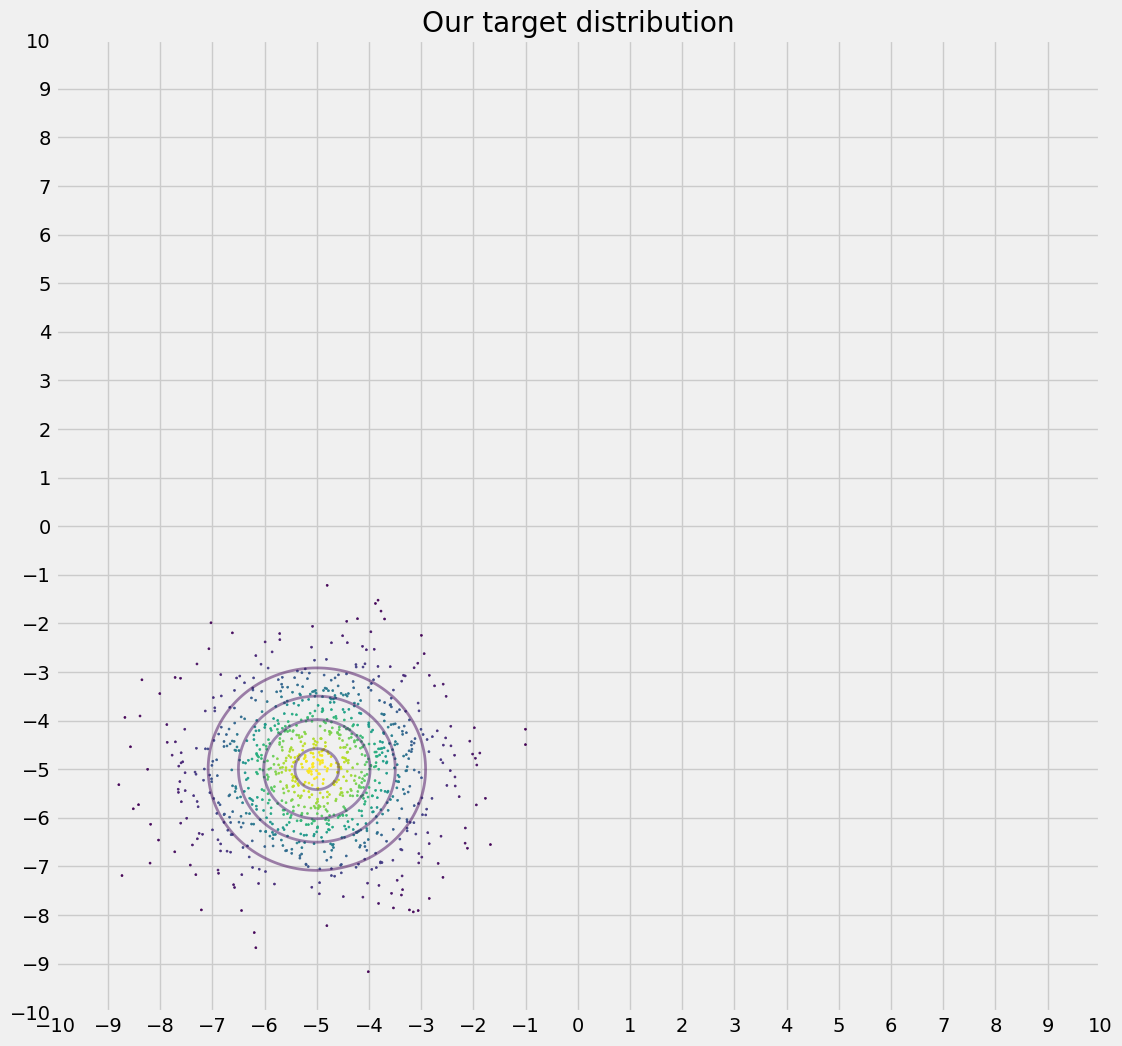

In [2]:
# Функция для создания распределения в удобном нам виде
def make_data(mu, sigma, num_examples):
    # Многомерное нормальное распределение
    dist = MultivariateNormal(mu, sigma)
    
    # Сэмплируем num_examples точек из выбранного распределения
    points = dist.sample([num_examples])
    
    # Для выбранного распределения и набора точек считаем вероятности этих точек (для цвета на графиках)
    probs = dist.log_prob(points).exp()
    
    # 95% интервал
    mu = mu.detach()
    sigma = sigma.detach()
    
    interval_k = 2.
    x = torch.linspace(
        mu[0].item() - interval_k * sigma[0,0].item(),
        mu[0].item() + interval_k * sigma[0,0].item(),
        100,
    )
    y = torch.linspace(
        mu[1].item() - interval_k * sigma[1,1].item(),
        mu[1].item() + interval_k * sigma[1,1].item(),
        100,
    )
    xgrid, ygrid = torch.meshgrid(x, y)
    z = dist.log_prob(torch.stack((xgrid, ygrid), dim=-1)).exp().detach()
    
    return dist, points, probs, (xgrid, ygrid, z)

# Функция для создания plot-а для отрисовки
def prep_plot(title):
    fig, ax = plt.subplots(figsize=(12, 12))
    plt.title(title)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.xticks(np.arange(-10, 11, 1.))
    plt.yticks(np.arange(-10, 11, 1.))

# Функция для отрисовки 2d точек
def plot2d(dots, probs=None, color=None, label=None, grid_data=None):
    assert probs is not None or color is not None
    plt.scatter(
        dots[:, 0].detach(),
        dots[:, 1].detach(),
        s=2.,
        c=color if probs is None else probs.detach(),
        label=label,
    )
    if grid_data is not None:
        cs = plt.contour(*grid_data, levels=4, colors=color, vmin=0., vmax=1., linewidths=2., alpha=0.5)
        if label:
            cs.collections[-1].set_label(f"{label} contour lines")


# Создаём target распределение
target_mu = torch.ones(2) * -5.
target_sigma = torch.eye(2, 2) * 1.5
target_dist, target, target_probs, target_grid = make_data(target_mu, target_sigma, 1000)

# Отрисовываем полученный набор точек, насэмплированных из нашего таргет распределения
prep_plot("Our target distribution")
plot2d(target, probs=target_probs, color=None, label="target", grid_data=target_grid)
plt.legend()
plt.show()

### 1.2 Создадим предсказания

/tmp/ipykernel_182562/3533768848.py:54: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  cs.collections[-1].set_label(f"{label} contour lines")


IndexError: list index out of range

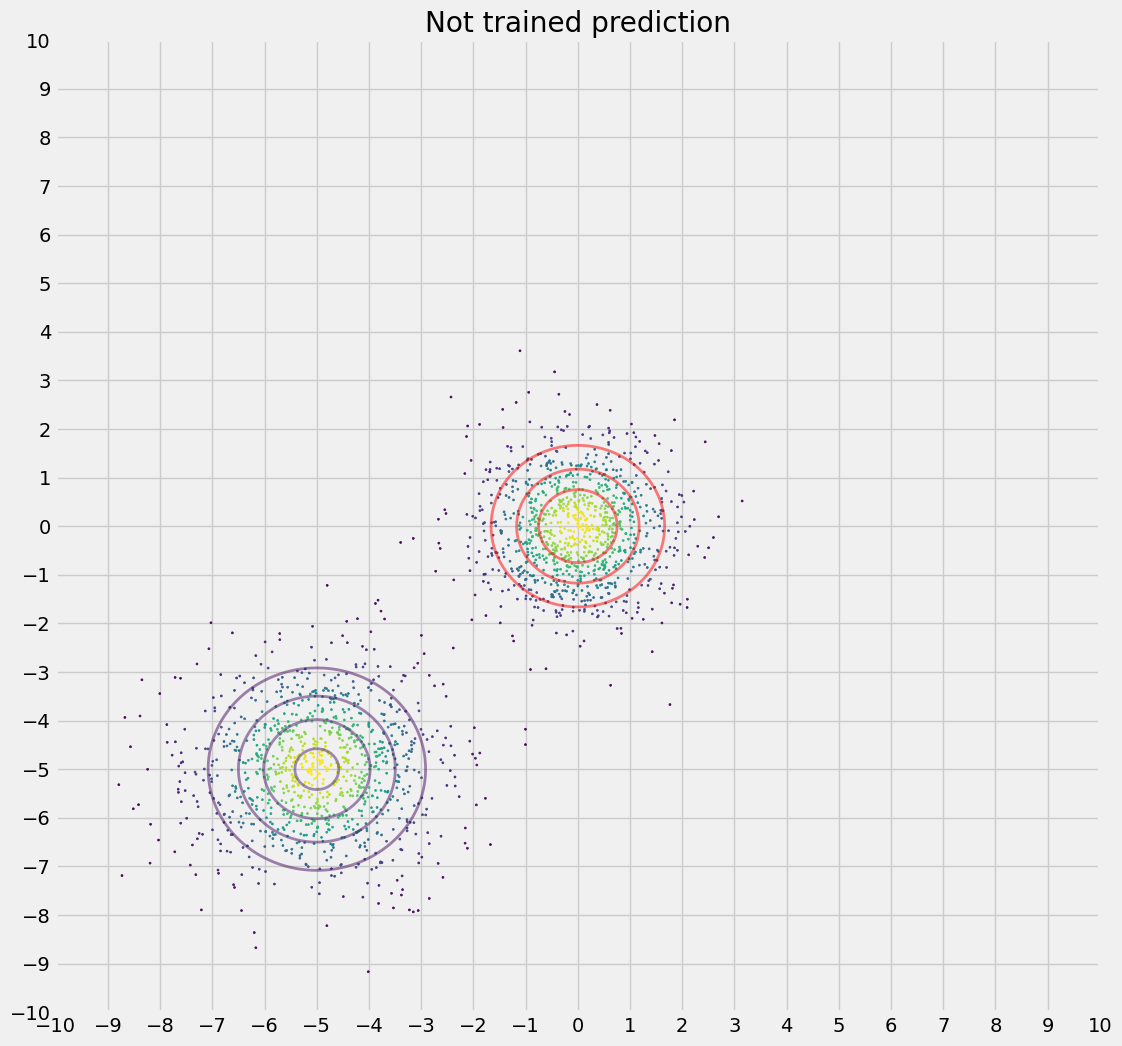

In [3]:
# Функция для получения обучаемоых параметров
def get_parameters(mu=0., sigma=1.):
    train_mu = torch.Tensor([mu, mu])
    train_mu.requires_grad=True
    train_sigma = torch.Tensor([[sigma, 0.0],
                                [0.0, sigma]])
    train_sigma.requires_grad=True
    return train_mu, train_sigma

# Создаём распределение предсказания
pred_mu, pred_sigma = get_parameters(mu=0., sigma=1.)
pred_dist, pred, pred_probs, pred_grid = make_data(pred_mu, pred_sigma, 1000)

# Отрисовываем полученный набор точек, насэмплированных из нашего таргет распределения
prep_plot("Not trained prediction")
plot2d(target, probs=target_probs, color=None, label="target", grid_data=target_grid)
plot2d(pred, probs=pred_probs, color="red", label="pred", grid_data=pred_grid)
plt.legend()
plt.show()

### 1.3 Попробуем различные функции расстояний

In [4]:
# Функция для обучения
def train(
    pred_mu,
    pred_sigma,
    optim,
    num_epochs,
    loss_fn,
    loss_name,
    target=target,
    target_probs=target_probs,
    target_grid=target_grid,
    reverse=False,
    weights=None,
):
    for i in trange(1, num_epochs + 1, 1):
        optim.zero_grad()
        pred_dist, pred, pred_probs, pred_grid = make_data(pred_mu, pred_sigma, 1000)

        # train_probs = q(x) = вероятности точек из target относительно распределения предсказания
        train_probs = pred_dist.log_prob(target).exp()
        if reverse:
            loss = loss_fn(train_probs, target_probs, weights)
        else:
            loss = loss_fn(target_probs, train_probs, weights)
        loss.backward()
        optim.step()

        if i % 50 == 0:
            # Отрисовываем
            clear_output(True)

            pred_dist, pred, pred_probs, pred_grid = make_data(pred_mu, pred_sigma, 1000)

            prep_plot(f"Prediction step #{i} - {loss_name} = {round(loss.item(), 5)}")
            plot2d(
                target,
                # probs=target_probs,
                color="red",
                label="target",
                grid_data=target_grid,
            )
            plot2d(
                pred,
                probs=pred_probs,
                # color="red",
                label="pred",
                grid_data=pred_grid,
            )
            plt.legend()
            plt.show()
    return pred_mu, pred_sigma, optim

#### 1.3.1 Total Variation Distance

$$D_{TVD}(p || q) = \int w_x \cdot | p(x) - q(x) | \; dx$$

$w_x$ - importance sampling weight (можем добавлять значимость объектам из выборки)

In [5]:
def tvd_loss(px, qx, weights=None):
    """
    px - torch.Tensor
    qx - torch.Tensor 
    weigths - object weights (when importance sampling is used)
    """
    if weights is None:
        weights = torch.ones_like(px)
    return torch.mean(weights * torch.abs(px - qx))

/tmp/ipykernel_182562/3533768848.py:54: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  cs.collections[-1].set_label(f"{label} contour lines")


IndexError: list index out of range

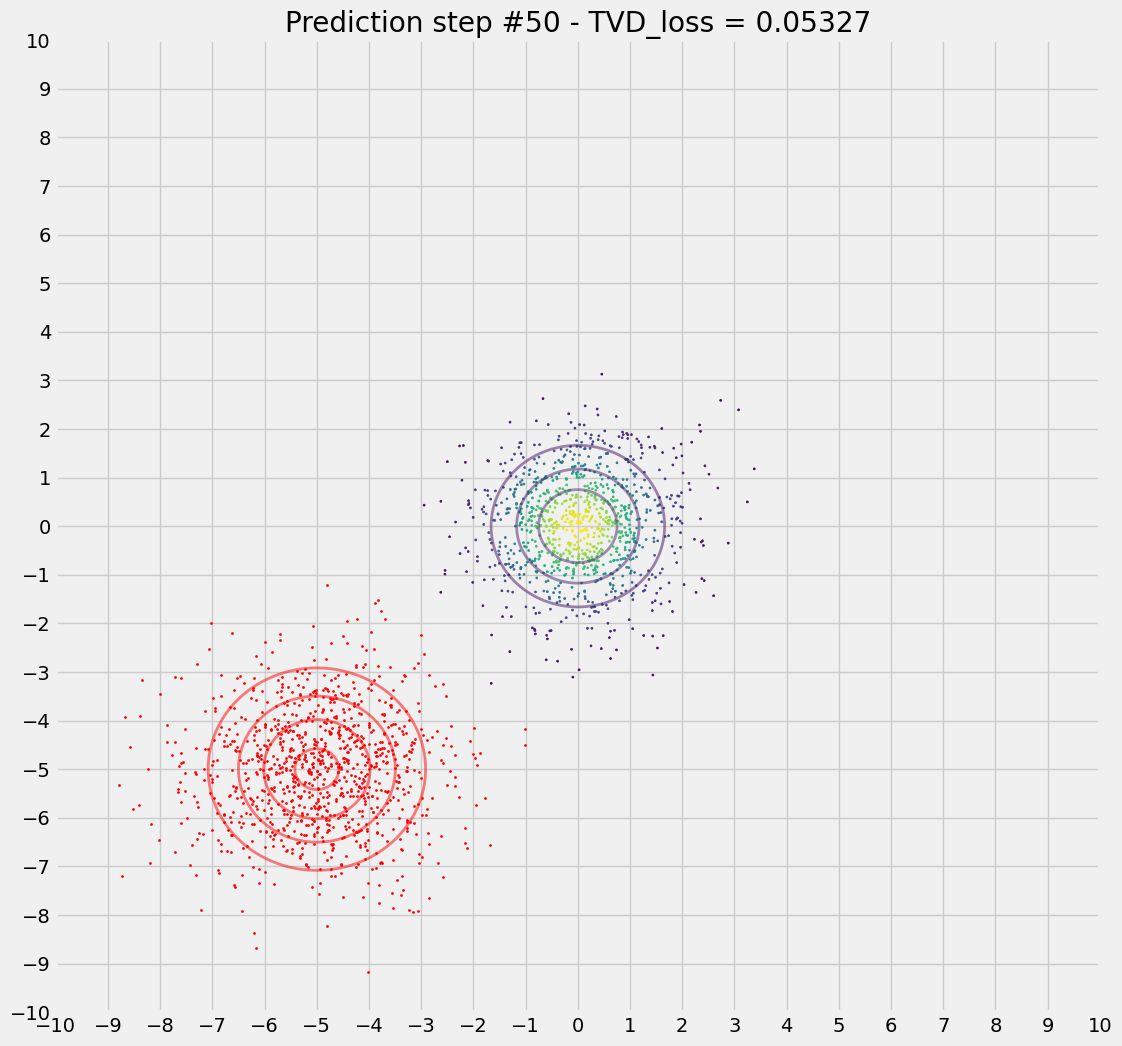

In [6]:
%%time
# Создаём обучаемое предсказание
pred_mu, pred_sigma = get_parameters(mu=0., sigma=1.)

# Можете попробовать Adam вместо SGD
optim = torch.optim.SGD([pred_mu, pred_sigma], lr=0.1)

# Обучаем распределение
pred_mu, pred_sigma, optim = train(
    pred_mu=pred_mu,
    pred_sigma=pred_sigma,
    optim=optim,
    num_epochs=2000,
    target=target,
    target_probs=target_probs,
    target_grid=target_grid,
    loss_fn=tvd_loss,
    loss_name="TVD_loss",
)

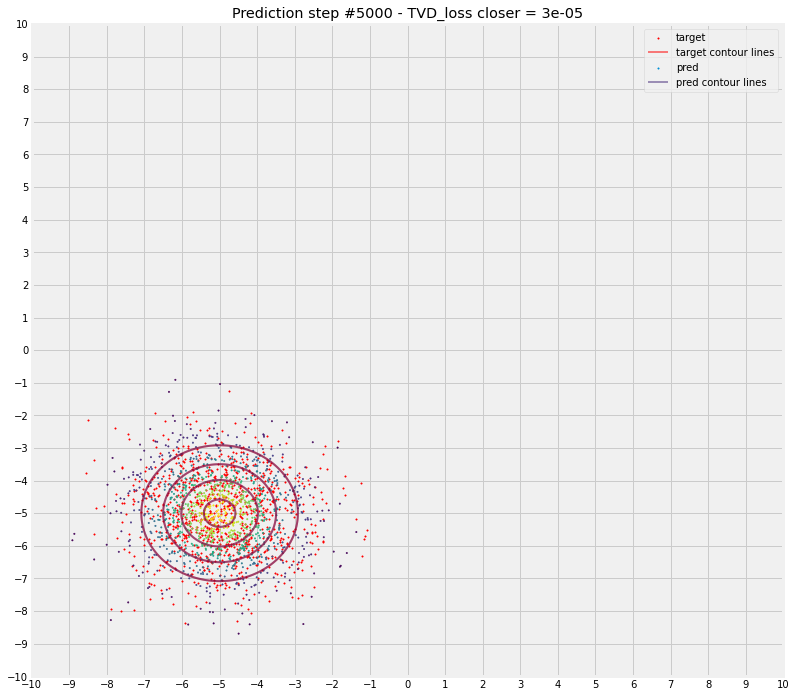


CPU times: user 41.5 s, sys: 1.01 s, total: 42.5 s
Wall time: 33.3 s


In [76]:
%%time
# Создаём обучаемое предсказание
pred_mu, pred_sigma = get_parameters(mu=-3., sigma=1.)

# Можете попробовать Adam вместо SGD
optim = torch.optim.SGD([pred_mu, pred_sigma], lr=0.1)

# Обучаем распределение
pred_mu, pred_sigma, optim = train(
    pred_mu=pred_mu,
    pred_sigma=pred_sigma,
    optim=optim,
    num_epochs=5000,
    target=target,
    target_probs=target_probs,
    target_grid=target_grid,
    loss_fn=tvd_loss,
    loss_name="TVD_loss closer",
)

#### 1.3.2 KL Divergence

$$D_{KL}(p || q) = \int w_x \cdot p(x) \cdot \log \bigg( \frac{p(x)}{q(x)} \bigg) \; dx$$

In [77]:
def kl_loss(px, qx, weights=None):
    # clamp (заменяем нули на очень маленькие значения для вычислительной стабильности)
    px, qx = px.clamp(min=1e-7), qx.clamp(min=1e-7)
    if weights is None:
        weights = torch.ones_like(px)
    return torch.mean(weights * px * (px.log() - qx.log()))

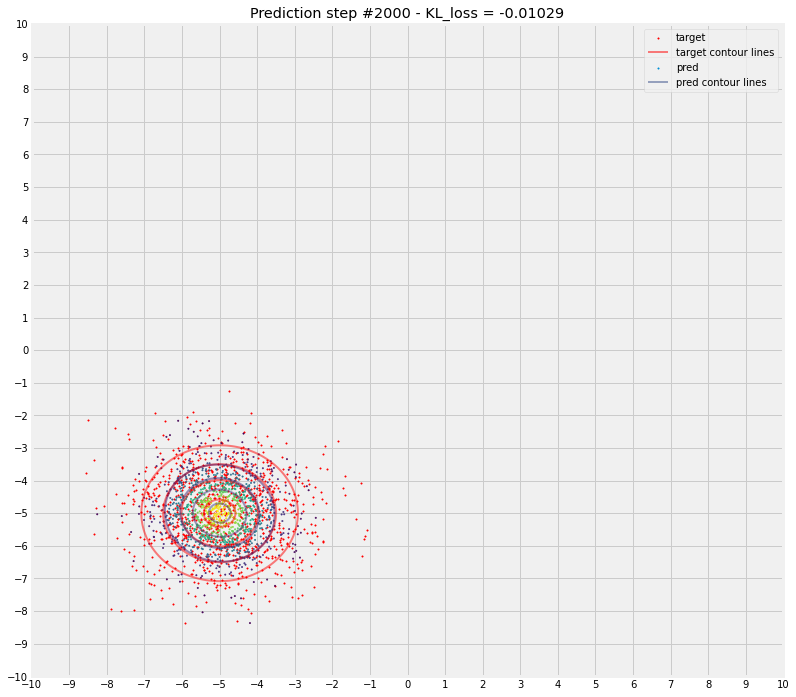


CPU times: user 17.1 s, sys: 426 ms, total: 17.5 s
Wall time: 13.6 s


In [78]:
%%time
# Создаём обучаемое предсказание
pred_mu, pred_sigma = get_parameters(mu=0., sigma=1.)

# Можете попробовать Adam вместо SGD
optim = torch.optim.Adam([pred_mu, pred_sigma], lr=0.1)

# Обучаем распределение
pred_mu, pred_sigma, optim = train(
    pred_mu=pred_mu,
    pred_sigma=pred_sigma,
    optim=optim,
    num_epochs=2000,
    target=target,
    target_probs=target_probs,
    target_grid=target_grid,
    loss_fn=kl_loss,
    loss_name="KL_loss",
)

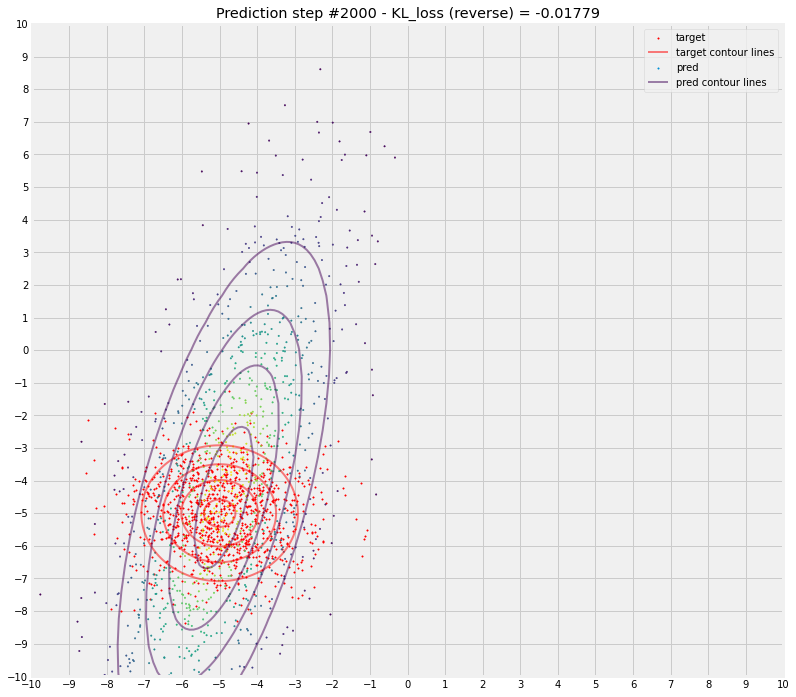


CPU times: user 17.6 s, sys: 421 ms, total: 18 s
Wall time: 14 s


In [79]:
%%time
# Создаём обучаемое предсказание
pred_mu, pred_sigma = get_parameters(mu=0., sigma=1.)

# Можете попробовать Adam вместо SGD
optim = torch.optim.Adam([pred_mu, pred_sigma], lr=0.1)

# Обучаем распределение
pred_mu, pred_sigma, optim = train(
    pred_mu=pred_mu,
    pred_sigma=pred_sigma,
    optim=optim,
    num_epochs=2000,
    target=target,
    target_probs=target_probs,
    target_grid=target_grid,
    loss_fn=kl_loss,
    loss_name="KL_loss (reverse)",
    reverse=True,
)

#### 1.3.3 JS Divergence

In [23]:
def js_loss(qx, px, weights=None):
    return (kl_loss(px, (px + qx) / 2., weights) + kl_loss(qx, (px + qx) / 2., weights)) / 2.

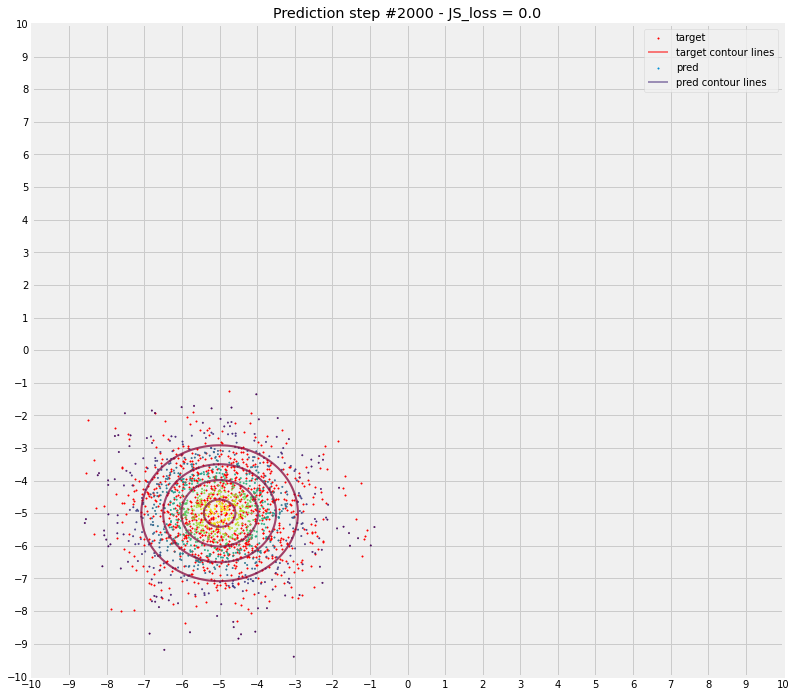


CPU times: user 18.1 s, sys: 370 ms, total: 18.5 s
Wall time: 14.1 s


In [81]:
%%time
# Создаём обучаемое предсказание
pred_mu, pred_sigma = get_parameters(mu=0., sigma=1.)

# Можете попробовать Adam вместо SGD
optim = torch.optim.Adam([pred_mu, pred_sigma], lr=0.1)

# Обучаем распределение
pred_mu, pred_sigma, optim = train(
    pred_mu=pred_mu,
    pred_sigma=pred_sigma,
    optim=optim,
    num_epochs=2000,
    target=target,
    target_probs=target_probs,
    target_grid=target_grid,
    loss_fn=js_loss,
    loss_name="JS_loss",
)

#### 1.3.4 Wasserstein Distance

Относительно просто произвольных распределений расчёт WD довольно хитрый и совсем не простой, делать сами не будем.

Обычно мы работаем с WD в форме дуальности Канторовича-Рубенштейна, где как функцию как раз берём дискриминатор из GAN-а и трюками обеспечиваем 1-Липшицевость для нейросети

### 1.4 Мультимодальный случай

А что если у нас больше чем одна мода - что именно будет приближаться одним нормальным распределением?

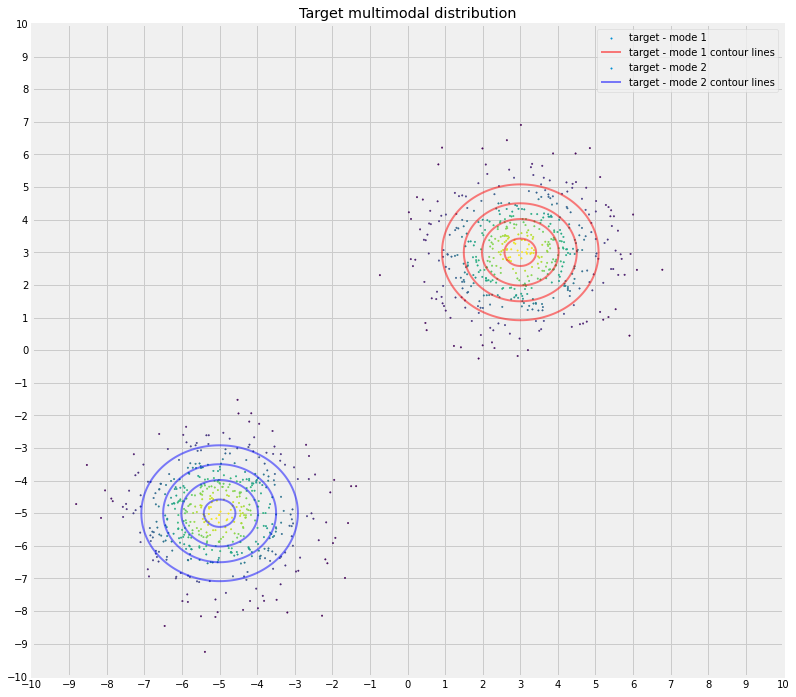

In [82]:
# Создаём target мультимодальное распределение
target_mu_1 = torch.ones(2) * 3.
target_sigma_1 = torch.eye(2, 2) * 1.5
target_dist_1, target_1, target_probs_1, target_grid_1 = make_data(target_mu_1, target_sigma_1, 500)

target_mu_2 = torch.ones(2) * -5.
target_sigma_2 = torch.eye(2, 2) * 1.5
target_dist_2, target_2, target_probs_2, target_grid_2 = make_data(target_mu_2, target_sigma_2, 500)

mm_target = torch.cat((target_1, target_2), dim=0)
mm_target_probs = torch.cat((target_probs_1, target_probs_2), dim=0)


# Отрисовываем полученный набор точек, насэмплированных из нашего таргет распределения
prep_plot("Target multimodal distribution")
plot2d(target_1, probs=target_probs_1, color="red", label="target - mode 1", grid_data=target_grid_1)
plot2d(target_2, probs=target_probs_2, color="blue", label="target - mode 2", grid_data=target_grid_2)
plt.legend()
plt.show()

#### 1.4.1 TVD

In [85]:
def mm_draw(pred_mu, pred_sigma, loss_name):
    # Отрисовываем
    clear_output(True)

    pred_dist, pred, pred_probs, pred_grid = make_data(pred_mu, pred_sigma, 1000)

    prep_plot(f"Prediction Final - {loss_name}")
    plot2d(
        target_1,
        # probs=target_probs,
        color="red",
        label="target",
        grid_data=target_grid_1,
    )
    plot2d(
        target_2,
        # probs=target_probs,
        color="red",
        # label="target",
        grid_data=target_grid_2,
    )
    plot2d(
        pred,
        probs=pred_probs,
        # color="red",
        label="pred",
        grid_data=pred_grid,
    )
    plt.legend()
    plt.show()

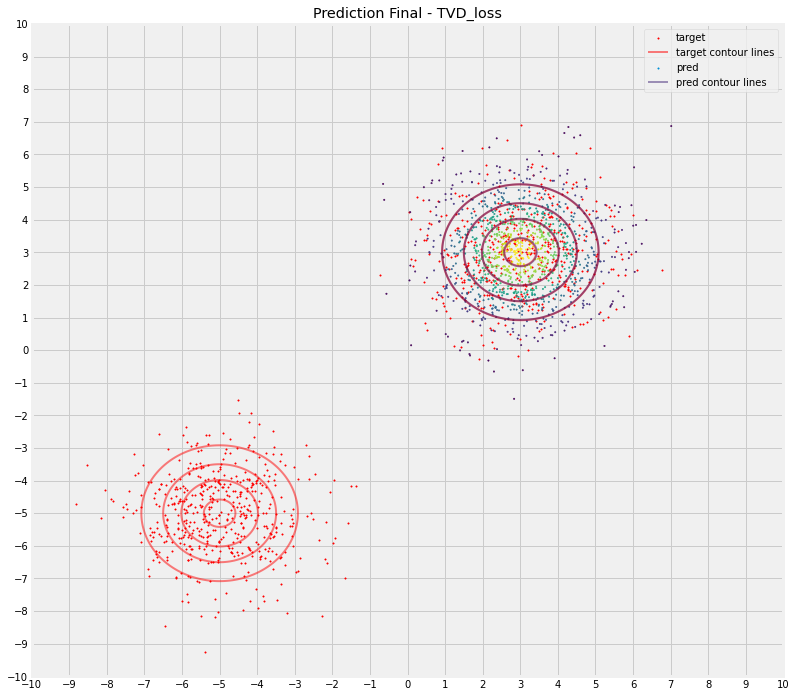

CPU times: user 17 s, sys: 362 ms, total: 17.3 s
Wall time: 13.4 s


In [86]:
%%time
# Создаём обучаемое предсказание
pred_mu, pred_sigma = get_parameters(mu=0., sigma=1.)

# Можете попробовать Adam вместо SGD
optim = torch.optim.Adam([pred_mu, pred_sigma], lr=0.1)

# Обучаем распределение
pred_mu, pred_sigma, optim = train(
    pred_mu=pred_mu,
    pred_sigma=pred_sigma,
    optim=optim,
    num_epochs=2000,
    target=mm_target,
    target_probs=mm_target_probs,
    target_grid=None,
    loss_fn=tvd_loss,
    loss_name="TVD_loss",
)

mm_draw(pred_mu, pred_sigma, "TVD_loss")

#### 1.4.2 KL

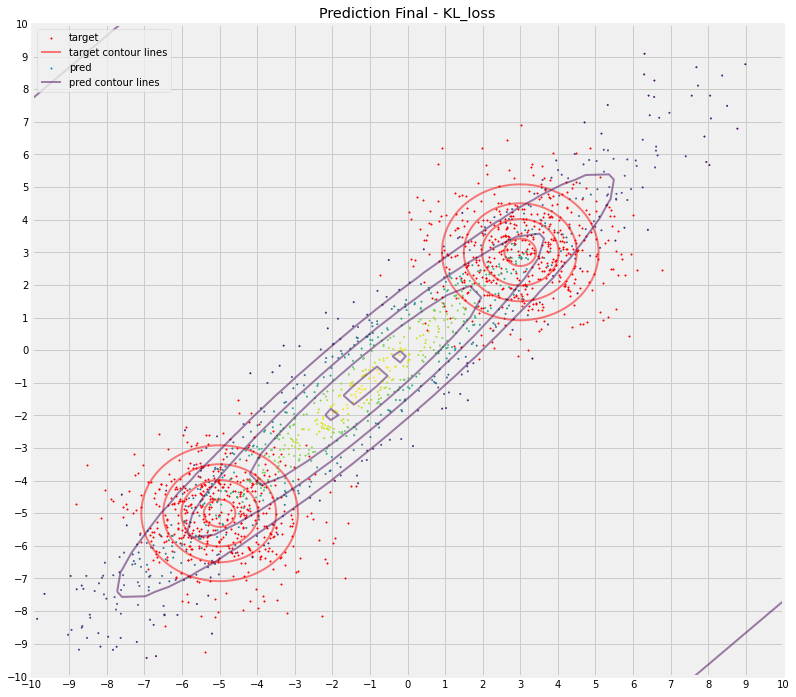

CPU times: user 18 s, sys: 397 ms, total: 18.4 s
Wall time: 14.1 s


In [88]:
%%time
# Создаём обучаемое предсказание
pred_mu, pred_sigma = get_parameters(mu=0., sigma=1.)

# Можете попробовать Adam вместо SGD
optim = torch.optim.Adam([pred_mu, pred_sigma], lr=0.1)

# Обучаем распределение
pred_mu, pred_sigma, optim = train(
    pred_mu=pred_mu,
    pred_sigma=pred_sigma,
    optim=optim,
    num_epochs=2000,
    target=mm_target,
    target_probs=mm_target_probs,
    target_grid=None,
    loss_fn=kl_loss,
    loss_name="KL_loss",
)

mm_draw(pred_mu, pred_sigma, "KL_loss")

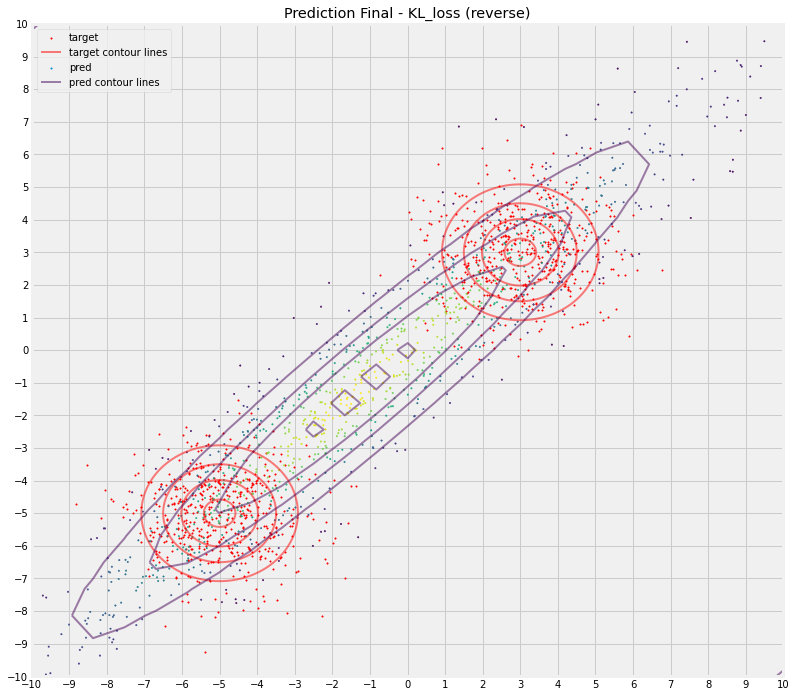

CPU times: user 18.3 s, sys: 398 ms, total: 18.7 s
Wall time: 14.3 s


In [89]:
%%time
# Создаём обучаемое предсказание
pred_mu, pred_sigma = get_parameters(mu=0., sigma=1.)

# Можете попробовать Adam вместо SGD
optim = torch.optim.Adam([pred_mu, pred_sigma], lr=0.1)

# Обучаем распределение
pred_mu, pred_sigma, optim = train(
    pred_mu=pred_mu,
    pred_sigma=pred_sigma,
    optim=optim,
    num_epochs=2000,
    target=mm_target,
    target_probs=mm_target_probs,
    target_grid=None,
    loss_fn=kl_loss,
    loss_name="KL_loss (reverse)",
    reverse=True,
)

mm_draw(pred_mu, pred_sigma, "KL_loss (reverse)")

#### 1.4.3 JS

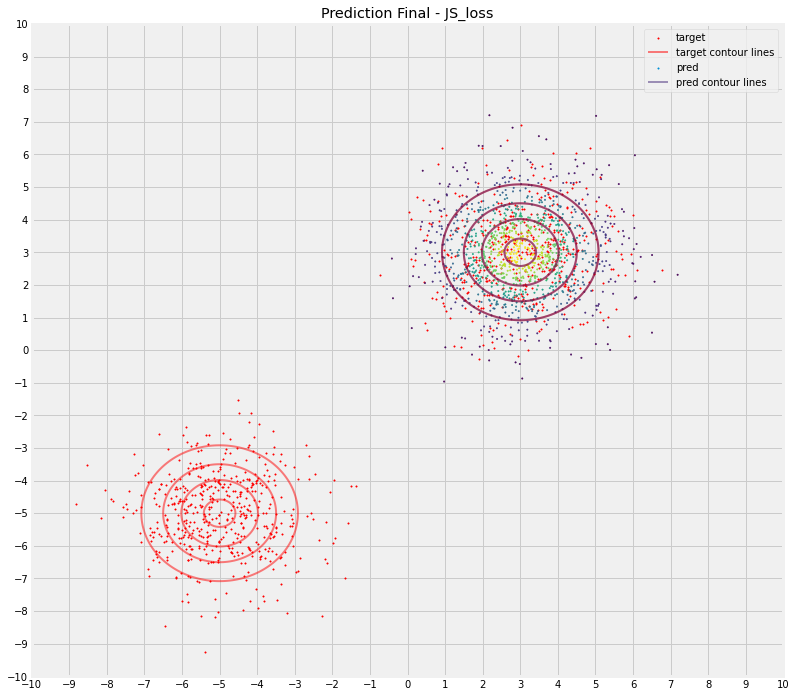

CPU times: user 18 s, sys: 402 ms, total: 18.4 s
Wall time: 14 s


In [90]:
%%time
# Создаём обучаемое предсказание
pred_mu, pred_sigma = get_parameters(mu=0., sigma=1.)

# Можете попробовать Adam вместо SGD
optim = torch.optim.Adam([pred_mu, pred_sigma], lr=0.1)

# Обучаем распределение
pred_mu, pred_sigma, optim = train(
    pred_mu=pred_mu,
    pred_sigma=pred_sigma,
    optim=optim,
    num_epochs=2000,
    target=mm_target,
    target_probs=mm_target_probs,
    target_grid=None,
    loss_fn=js_loss,
    loss_name="JS_loss",
)

mm_draw(pred_mu, pred_sigma, "JS_loss")

## 2. Подготовим данные и основные блоки модели

In [7]:
from torch import nn
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as tr

### 2.1 Данные

In [3]:
train_data = datasets.FashionMNIST(
    root="/home/jupyter/datasphere/project/datasets",
    train=True,
    download=True,
)

val_data = datasets.FashionMNIST(
    root="/home/jupyter/datasphere/project/datasets",
    train=False,
    download=True,
)

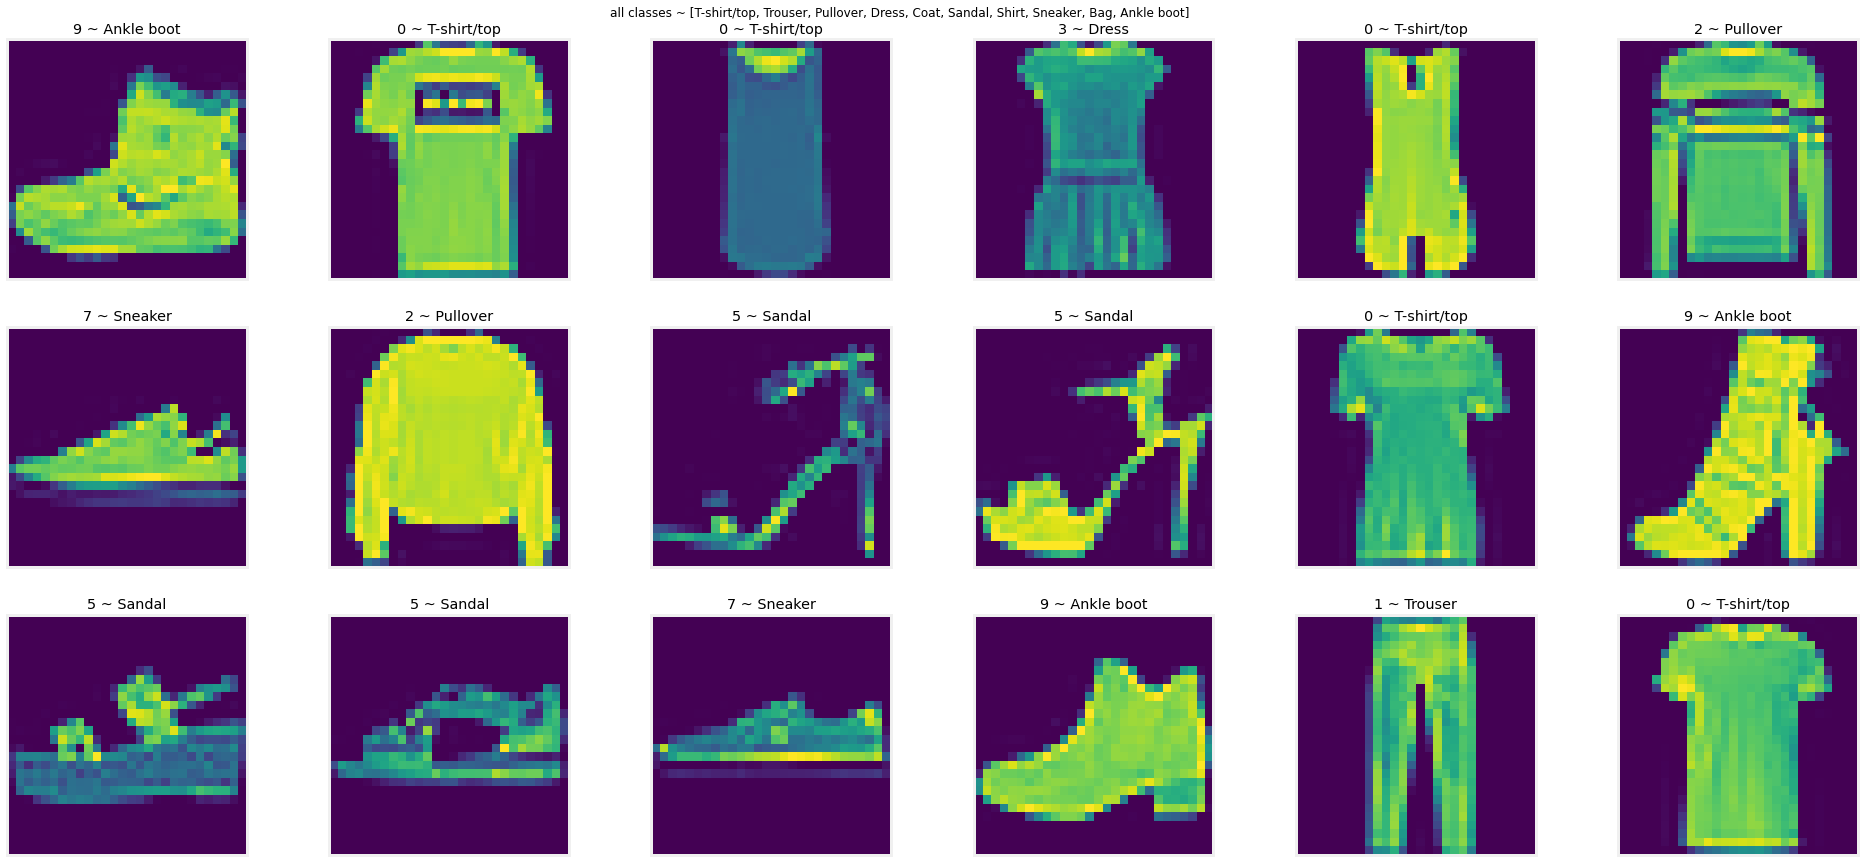

In [4]:
classes = train_data.classes

h = 3
w = 6
fig, ax = plt.subplots(h, w, figsize=(30, 15))

fig.suptitle(f"all classes ~ [{', '.join(classes)}]", y=0.85 + 0.02*h)
for i in range(h * w):
    plt.subplot(h, w, i+1)
    img, cl = train_data[i]
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title(f"{cl} ~ {classes[cl]}")
plt.show()

In [5]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /home/jupyter/datasphere/project/datasets
    Split: Train

In [6]:
val_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: /home/jupyter/datasphere/project/datasets
    Split: Test

In [7]:
train_data[0][0].size

(28, 28)

In [8]:
mean, std = 0, 0
for img, cl in tqdm(train_data):
    img = np.array(img) / 255.
    mean += img.mean()
    std += img.std()
mean /= len(train_data)
std /= len(train_data)

print(mean, std)


0.2860405969887968 0.32024892543116534


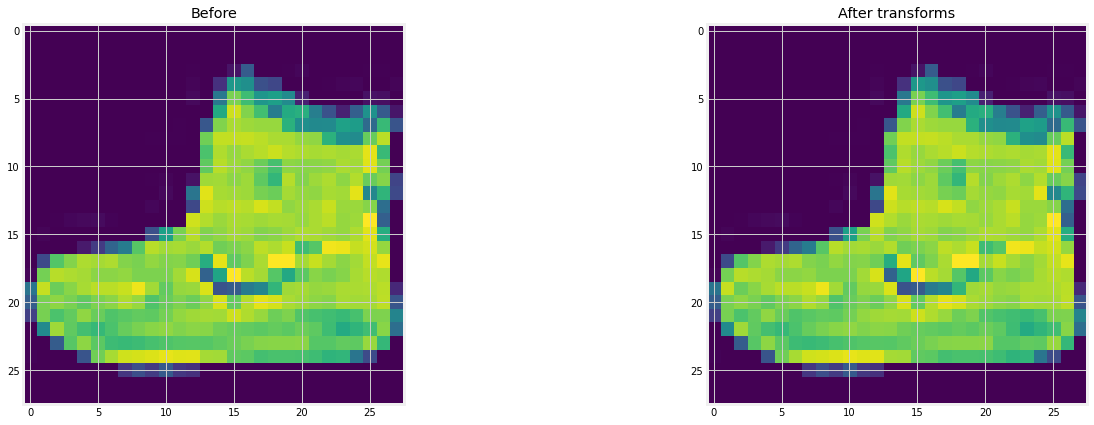

In [28]:
transforms = tr.Compose([
    tr.RandomHorizontalFlip(),
    tr.ToTensor(),
    tr.Normalize(mean=mean, std=std),
])


def de_normalize(img):
    img = img.detach().cpu().numpy().transpose((1, 2, 0))
    return img * std + mean


img_ind = 0

fig, ax = plt.subplots(1, 2, figsize=(20, 7))

plt.subplot(121)
plt.imshow(train_data[img_ind][0])
plt.title("Before")

plt.subplot(122)
plt.imshow(de_normalize(transforms(train_data[img_ind][0])))
plt.title("After transforms")

plt.show()

In [38]:
class ImageDataset(Dataset):
    def __init__(self, dataset, transforms):
        super(ImageDataset).__init__()
        self.dataset = dataset
        self.transforms = transforms

    def __getitem__(self, index):
        img, cl = self.dataset[index]
        return self.transforms(img), cl
    
    def __len__(self):
        return len(self.dataset)

train_ds = ImageDataset(train_data, transforms)
val_ds = ImageDataset(val_data, transforms)

batch_size = 2000

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)

val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
)

### 2.2 Residual block общего вида

In [11]:
from collections import OrderedDict
from functools import partial

class ResidualBlock(nn.Module):
    def __init__(self, c_in, c_out, kernel_size, n_layers, activation_class=nn.ReLU, dropout_p=0.3, reverse=False, do_scale=True, change_size=0):
        super(ResidualBlock, self).__init__()
        
        self.c_in = c_in
        self.c_out = c_out
        self.kernel_size = kernel_size
        self.n_layers = n_layers
        self.activation_class = activation_class
        self.dropout_p = dropout_p
        self.reverse = reverse
        self.do_scale = do_scale
        self.change_size = change_size
        
        if self.reverse:
            self.conv_class = nn.ConvTranspose2d
            self.scale_class = partial(
                nn.ConvTranspose2d,
                in_channels=self.c_out,
                out_channels=self.c_out,
                stride=2,
            )
            self.conv_name_prefix = "deconv"
            self.scale_name = "upscale"
            self.change_name = "add_size"
        else:
            self.conv_class = nn.Conv2d
            self.scale_class = nn.MaxPool2d
            self.conv_name_prefix = "conv"
            self.scale_name = "downscale"
            self.change_name = "sub_size"
        
        layers = [
            nn.Sequential(OrderedDict([
                (
                    self.conv_name_prefix,
                    self.conv_class(
                        in_channels = self.c_in if i == 0 else self.c_out,
                        out_channels = self.c_out,
                        kernel_size = self.kernel_size,
                        padding = (self.kernel_size - 1) // 2,
                        bias=False,
                    ),
                ),
                ("bnorm", nn.BatchNorm2d(self.c_out)),
                ("act", self.activation_class()),
                ("drop", nn.Dropout2d(self.dropout_p)),
            ])) for i in range(self.n_layers)
        ]
        
        self.layers = nn.Sequential(OrderedDict([(f"layer_{i}", layer) for i, layer in enumerate(layers)]))
        
        self.adapt_residual = nn.Identity() if self.c_in == self.c_out else self.conv_class(self.c_in, self.c_out, 1)
        
        scale = [
            (self.change_name, self.conv_class(self.c_out, self.c_out, self.change_size + 1) if self.change_size > 0 else nn.Identity()),
            (self.scale_name, self.scale_class(kernel_size=2) if self.do_scale else nn.Identity()),
        ]
        self.scale = nn.Sequential(OrderedDict(scale))
        
    
    def forward(self, x):
        return self.scale(self.layers(x) + self.adapt_residual(x))

In [12]:
encoder_res_block = ResidualBlock(
    c_in=2,
    c_out=4,
    kernel_size=3,
    n_layers=5,
    activation_class=nn.ReLU,
    dropout_p=0.3,
    reverse=False,
    do_scale=True,
    change_size=0,
)
print(encoder_res_block)

tmp_in = torch.rand(1, 2, 10, 10)
tmp_out = encoder_res_block(tmp_in)

print(
    "---------",
    f"input shape: {list(tmp_in.shape)}",
    f"output shape: {list(tmp_out.shape)}",
    sep="\n",
)

ResidualBlock(
  (layers): Sequential(
    (layer_0): Sequential(
      (conv): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bnorm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
      (drop): Dropout2d(p=0.3, inplace=False)
    )
    (layer_1): Sequential(
      (conv): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bnorm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
      (drop): Dropout2d(p=0.3, inplace=False)
    )
    (layer_2): Sequential(
      (conv): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bnorm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
      (drop): Dropout2d(p=0.3, inplace=False)
    )
    (layer_3): Sequential(
      (conv): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fa

In [13]:
decoder_res_block = ResidualBlock(
    c_in=2,
    c_out=4,
    kernel_size=3,
    n_layers=5,
    activation_class=nn.Tanh,
    dropout_p=0.1,
    reverse=True,
    do_scale=True,
    change_size=0,
)
print(decoder_res_block)

tmp_in = torch.rand(1, 2, 10, 10)
tmp_out = decoder_res_block(tmp_in)

print(
    "---------",
    f"input shape: {list(tmp_in.shape)}",
    f"output shape: {list(tmp_out.shape)}",
    sep="\n",
)

ResidualBlock(
  (layers): Sequential(
    (layer_0): Sequential(
      (deconv): ConvTranspose2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bnorm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): Tanh()
      (drop): Dropout2d(p=0.1, inplace=False)
    )
    (layer_1): Sequential(
      (deconv): ConvTranspose2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bnorm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): Tanh()
      (drop): Dropout2d(p=0.1, inplace=False)
    )
    (layer_2): Sequential(
      (deconv): ConvTranspose2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bnorm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): Tanh()
      (drop): Dropout2d(p=0.1, inplace=False)
    )
    (layer_3): Sequential(
      (deconv): ConvTranspose2d(4, 4, kernel_size=(3

In [14]:
decoder_res_block = ResidualBlock(
    c_in=2,
    c_out=4,
    kernel_size=3,
    n_layers=5,
    activation_class=nn.Sigmoid,
    dropout_p=0.,
    reverse=True,
    do_scale=False,
    change_size=4,
)
print(decoder_res_block)

tmp_in = torch.rand(1, 2, 10, 10)
tmp_out = decoder_res_block(tmp_in)

print(
    "---------",
    f"input shape: {list(tmp_in.shape)}",
    f"output shape: {list(tmp_out.shape)}",
    sep="\n",
)

ResidualBlock(
  (layers): Sequential(
    (layer_0): Sequential(
      (deconv): ConvTranspose2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bnorm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): Sigmoid()
      (drop): Dropout2d(p=0.0, inplace=False)
    )
    (layer_1): Sequential(
      (deconv): ConvTranspose2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bnorm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): Sigmoid()
      (drop): Dropout2d(p=0.0, inplace=False)
    )
    (layer_2): Sequential(
      (deconv): ConvTranspose2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bnorm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): Sigmoid()
      (drop): Dropout2d(p=0.0, inplace=False)
    )
    (layer_3): Sequential(
      (deconv): ConvTranspose2d(4, 4, kerne

### 2.3 Энкодер

In [15]:
class Encoder(nn.Module):
    def __init__(self, num_blocks, block_sizes, hidden_sizes, kernel_sizes, activation_classes, use_scales, change_sizes, dropout_ps, fc_size=0):
        super(Encoder, self).__init__()
        
        def fill_list(val, size):
            if isinstance(val, list):
                assert len(val) == size
                return val
            return [val for _ in range(size)]
        
        self.num_blocks = num_blocks
        self.block_sizes = fill_list(block_sizes, self.num_blocks)
        self.hidden_sizes = [1] + fill_list(hidden_sizes, self.num_blocks)
        self.kernel_sizes = fill_list(kernel_sizes, self.num_blocks)
        self.activation_classes = fill_list(activation_classes, self.num_blocks)
        self.use_scales = fill_list(use_scales, self.num_blocks)
        self.change_sizes = fill_list(change_sizes, self.num_blocks)
        self.dropout_ps = fill_list(dropout_ps, self.num_blocks)
        self.fc_size = fc_size
        
        self.residual_blocks = nn.Sequential(OrderedDict([
            (
                f"residual_{i}",
                ResidualBlock(
                    c_in=self.hidden_sizes[i],
                    c_out=self.hidden_sizes[i+1],
                    kernel_size=self.kernel_sizes[i],
                    n_layers=self.block_sizes[i],
                    activation_class=self.activation_classes[i],
                    dropout_p=self.dropout_ps[i],
                    reverse=False,
                    do_scale=self.use_scales[i],
                    change_size=self.change_sizes[i],
                ),
            ) for i in range(self.num_blocks)
        ]))
        
        self.global_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1)) if self.fc_size > 0 else nn.Identity()
        self.fc = nn.Linear(self.hidden_sizes[-1], self.fc_size) if self.fc_size > 0 else nn.Identity()
    
    def forward(self, x):
        out = self.residual_blocks(x)
        out = self.global_pool(out).squeeze(-1).squeeze(-1)
        return self.fc(out)

In [16]:
encoder = Encoder(
    num_blocks=2,
    block_sizes=[2, 3],
    hidden_sizes=[4, 8],
    kernel_sizes=3,
    activation_classes=nn.ReLU,
    use_scales=[True, False],
    change_sizes=[0, 1],
    dropout_ps=0.1,
    fc_size=7,
)

print(encoder)

tmp_in = torch.rand(2, 1, 10, 10)
tmp_out = encoder(tmp_in)

print(
    "---------",
    f"input shape: {list(tmp_in.shape)}",
    f"output shape: {list(tmp_out.shape)}",
    sep="\n",
)

Encoder(
  (residual_blocks): Sequential(
    (residual_0): ResidualBlock(
      (layers): Sequential(
        (layer_0): Sequential(
          (conv): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bnorm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): ReLU()
          (drop): Dropout2d(p=0.1, inplace=False)
        )
        (layer_1): Sequential(
          (conv): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bnorm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): ReLU()
          (drop): Dropout2d(p=0.1, inplace=False)
        )
      )
      (adapt_residual): Conv2d(1, 4, kernel_size=(1, 1), stride=(1, 1))
      (scale): Sequential(
        (sub_size): Identity()
        (downscale): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (residual_1): ResidualBlock(
  

### 2.4 Декодер

In [17]:
class Decoder(nn.Module):
    def __init__(self, num_blocks, block_sizes, hidden_sizes, kernel_sizes, activation_classes, use_scales, change_sizes, dropout_ps):
        super(Decoder, self).__init__()
        
        def fill_list(val, size):
            if isinstance(val, list):
                assert len(val) == size
                return val
            return [val for _ in range(size)]
        
        self.num_blocks = num_blocks
        self.block_sizes = fill_list(block_sizes, self.num_blocks)
        self.hidden_sizes = fill_list(hidden_sizes, self.num_blocks + 1)
        self.kernel_sizes = fill_list(kernel_sizes, self.num_blocks)
        self.activation_classes = fill_list(activation_classes, self.num_blocks)
        self.use_scales = fill_list(use_scales, self.num_blocks)
        self.change_sizes = fill_list(change_sizes, self.num_blocks)
        self.dropout_ps = fill_list(dropout_ps, self.num_blocks)
    
        self.residual_blocks = nn.Sequential(OrderedDict([
            (
                f"residual_{i}",
                ResidualBlock(
                    c_in=self.hidden_sizes[i],
                    c_out=self.hidden_sizes[i+1],
                    kernel_size=self.kernel_sizes[i],
                    n_layers=self.block_sizes[i],
                    activation_class=self.activation_classes[i],
                    dropout_p=self.dropout_ps[i],
                    reverse=True,
                    do_scale=self.use_scales[i],
                    change_size=self.change_sizes[i],
                ),
            ) for i in range(self.num_blocks)
        ]))
        
    def forward(self, x):
        return self.residual_blocks(x)

In [18]:
decoder = Decoder(
    num_blocks=2,
    block_sizes=[2, 3],
    hidden_sizes=[1, 4, 8],
    kernel_sizes=3,
    activation_classes=nn.ReLU,
    use_scales=[True, False],
    change_sizes=[0, 1],
    dropout_ps=0.1,
)

print(decoder)

tmp_in = torch.rand(2, 1, 10, 10)
tmp_out = decoder(tmp_in)

print(
    "---------",
    f"input shape: {list(tmp_in.shape)}",
    f"output shape: {list(tmp_out.shape)}",
    sep="\n",
)

Decoder(
  (residual_blocks): Sequential(
    (residual_0): ResidualBlock(
      (layers): Sequential(
        (layer_0): Sequential(
          (deconv): ConvTranspose2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bnorm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): ReLU()
          (drop): Dropout2d(p=0.1, inplace=False)
        )
        (layer_1): Sequential(
          (deconv): ConvTranspose2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bnorm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): ReLU()
          (drop): Dropout2d(p=0.1, inplace=False)
        )
      )
      (adapt_residual): ConvTranspose2d(1, 4, kernel_size=(1, 1), stride=(1, 1))
      (scale): Sequential(
        (add_size): Identity()
        (upscale): ConvTranspose2d(4, 4, kernel_size=(2, 2), stride=(2, 2))
      )
    )
    (residual_1): Residu

## 3. VAE

In [19]:
class VAE(nn.Module):
    def __init__(self, hid_size):
        super(VAE, self).__init__()
        
        self.hid_size = hid_size
    
        # 1x28x28 --> 8x14x14 --> 8x7x7 --> 16x3x3 --> 16 --> 32
        self.encoder = Encoder(
            num_blocks=3,
            block_sizes=[2, 2, 2],
            hidden_sizes=[8, 8, 16],
            kernel_sizes=3,
            activation_classes=nn.ReLU,
            use_scales=[True, True, True],
            change_sizes=[0, 0, 1],
            dropout_ps=[0., 0., 0.125],
            fc_size=self.hid_size * 2,
        )
        
        # 16x1x1 --> 16x6x6 --> 8x14x14 --> 4x28x28 --> 1x28x28
        self.decoder = Decoder(
            num_blocks=4,
            block_sizes=[2, 2, 2, 2],
            hidden_sizes=[self.hid_size, 16, 8, 4, 1],
            kernel_sizes=3,
            activation_classes=[nn.ReLU, nn.ReLU, nn.ReLU, nn.Sigmoid],
            use_scales=[True, True, True, False],
            change_sizes=[2, 1, 0, 0],
            dropout_ps=0.,
        )
        
    def forward(self, x):  # bs x 1 x 28 x 28
        z_stat = self.encoder(x)  # bs x 32
        
        hid_size = z_stat.shape[-1] // 2
        mu = z_stat[:, :hid_size]
        logvar = z_stat[:, hid_size:]
        
        # reparametrization trick  # bs x 16
        z = torch.randn(x.shape[0], hid_size).to(x.device) * torch.exp(logvar / 2.) + mu
        
        x_rec = self.decoder(z[:, :, None, None])
        
        return x_rec, (mu, logvar)

In [20]:
vae = VAE(hid_size=16)

print(vae)

tmp_in = torch.rand(2, 1, 28, 28)
tmp_out, tmp_stat = vae(tmp_in)

print(
    "---------",
    f"input shape: {list(tmp_in.shape)}",
    f"output shape: {list(tmp_out.shape)}",
    sep="\n",
)

VAE(
  (encoder): Encoder(
    (residual_blocks): Sequential(
      (residual_0): ResidualBlock(
        (layers): Sequential(
          (layer_0): Sequential(
            (conv): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bnorm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act): ReLU()
            (drop): Dropout2d(p=0.0, inplace=False)
          )
          (layer_1): Sequential(
            (conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bnorm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act): ReLU()
            (drop): Dropout2d(p=0.0, inplace=False)
          )
        )
        (adapt_residual): Conv2d(1, 8, kernel_size=(1, 1), stride=(1, 1))
        (scale): Sequential(
          (sub_size): Identity()
          (downscale): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mod

In [21]:
from collections import defaultdict
from termcolor import colored


def beautiful_int(i):
    i = str(i)
    return ".".join(reversed([i[max(j, 0):j+3] for j in range(len(i) - 3, -3, -3)]))


# Counting how many parameters does our model have
def model_num_params(model, verbose_all=True, verbose_only_learnable=False):
    sum_params = 0
    sum_learnable_params = 0
    submodules = defaultdict(lambda : [0, 0])
    for name, param in model.named_parameters():
        num_params = param.numel()
        if verbose_all or (verbose_only_learnable and param.requires_grad):
            print(
                colored(
                    '{: <65} ~  {: <9} params ~ grad: {}'.format(
                        name,
                        beautiful_int(num_params),
                        param.requires_grad,
                    ),
                    {True: "green", False: "red"}[param.requires_grad],
                )
            )
        sum_params += num_params
        sm = name.split(".")[0]
        submodules[sm][0] += num_params
        if param.requires_grad:
            sum_learnable_params += num_params
            submodules[sm][1] += num_params
    print(
        f'\nIn total:\n  - {beautiful_int(sum_params)} params\n  - {beautiful_int(sum_learnable_params)} learnable params'
    )
    
    for sm, v in submodules.items():
        print(
            f"\n . {sm}:\n .   - {beautiful_int(submodules[sm][0])} params\n .   - {beautiful_int(submodules[sm][1])} learnable params"
        )
    return sum_params, sum_learnable_params

sum_params, sum_learnable_params = model_num_params(vae)

encoder.residual_blocks.residual_0.layers.layer_0.conv.weight     ~  72        params ~ grad: True
encoder.residual_blocks.residual_0.layers.layer_0.bnorm.weight    ~  8         params ~ grad: True
encoder.residual_blocks.residual_0.layers.layer_0.bnorm.bias      ~  8         params ~ grad: True
encoder.residual_blocks.residual_0.layers.layer_1.conv.weight     ~  576       params ~ grad: True
encoder.residual_blocks.residual_0.layers.layer_1.bnorm.weight    ~  8         params ~ grad: True
encoder.residual_blocks.residual_0.layers.layer_1.bnorm.bias      ~  8         params ~ grad: True
encoder.residual_blocks.residual_0.adapt_residual.weight          ~  8         params ~ grad: True
encoder.residual_blocks.residual_0.adapt_residual.bias            ~  8         params ~ grad: True
encoder.residual_blocks.residual_1.layers.layer_0.conv.weight     ~  576       params ~ grad: True
encoder.residual_blocks.residual_1.layers.layer_0.bnorm.weight    ~  8         params ~ grad: True
encoder.re

### 3.1 Loss

In [22]:
def vae_loss(x_rec, x, mu, logvar, alpha=0.5, show_log=False):
    reconstruct_loss = ((x_rec - x)**2).sum((1, 2, 3)).mean()
    kl_loss = 0.5 * (mu**2 - logvar - 1 + torch.exp(logvar)).sum(-1).mean()
    if show_log:
        print('KL = {}, MSE = {}'.format(kl_loss, reconstruct_loss))
    return alpha * reconstruct_loss + (1 - alpha) * kl_loss

In [23]:
vae_loss(tmp_out, tmp_in, *tmp_stat, 0.9, True)

KL = 1.9773951768875122, MSE = 645.255126953125


tensor(580.9274, grad_fn=<AddBackward0>)

### 3.2 Train

In [24]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

def create_model_and_optimizer(model_class, model_params, lr=1e-3, beta1=0.9, beta2=0.999, device=device):
    model = model_class(**model_params).float()
    model = model.to(device)
    
    optimizer = torch.optim.Adam([param for param in model.parameters() if param.requires_grad], lr, [beta1, beta2])
    return model, optimizer

model, optimizer = create_model_and_optimizer(
    model_class = VAE,
    model_params = dict(hid_size = 16),
    lr = 1e-3,
    device = device,
)

In [35]:
from collections import defaultdict

def train(model, opt, loader, criterion):
    model.train()
    losses_tr = []
    for imgs, _ in tqdm(loader):
        imgs = imgs.to(device)
        
        optimizer.zero_grad()
        imgs_rec, (mu, logvar) = model(imgs)
        loss = criterion(imgs_rec, imgs, mu, logvar)
        
        loss.backward()
        optimizer.step()
        losses_tr.append(loss.item())
    
    return model, optimizer, np.mean(losses_tr)


def val(model, loader, criterion):
    model.eval()
    losses_val = []
    with torch.no_grad():
        for imgs, _ in tqdm(loader):
            imgs = imgs.to(device)
            
            imgs_rec, (mu, logvar) = model(imgs)
            loss = criterion(imgs_rec, imgs, mu, logvar)

            losses_val.append(loss.item())
    
    return np.mean(losses_val)

In [54]:
from IPython.display import clear_output
import warnings
import os
import copy

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

results = []

def draw_imgs(h, w):
    global results
    model.eval()
    fig, ax = plt.subplots(h, w, figsize=(30, 10))
    with torch.no_grad():
        pred = model.decoder(torch.randn(h * w, 100, 1, 1).to(device))
        to_draw = [de_normalize(pred[ind]) for ind in range(h * w)]
        results.append(copy.deepcopy(to_draw))
        
        for hh in range(h):
            for ww in range(w):
                ind = hh * w + ww
                plt.subplot(h, w, ind + 1)
                plt.imshow(to_draw[ind])
    plt.show()


def learning_loop(
    model,
    optimizer,
    train_loader,
    val_loader,
    criterion,
    scheduler=None,
    min_lr=None,
    epochs=10,
    val_every=1,
    draw_every=1,
    separate_show=False,
    model_name=None,
    chkp_folder="./chkps",
):
    if model_name is None:
        if os.exists(chkp_folder):
            num_starts = len(os.listdir(chkp_folder)) + 1
        else:
            num_starts = 1
        model_name = f'model#{num_starts}'
    if os.path.isfile(os.path.join(chkp_folder, model_name + '.pt')):
        model_name = model_name + "_v2"
        warnings.warn(f"Selected model_name was used already! To avoid possible overwrite - model_name changed to {model_name}")
    losses = {'train': [], 'val': []}
    lrs = []
    best_val_loss = np.Inf

    for epoch in range(1, epochs+1):
        print(f'#{epoch}/{epochs}:')

        lrs.append(get_lr(optimizer))
        
        model, optimizer, loss = train(model, optimizer, train_loader, criterion)
        losses['train'].append(loss)

        if not (epoch % val_every):
            loss = val(model, val_loader, criterion)
            losses['val'].append(loss)
            
            # Сохраняем лучшую по валидации модель
            if loss < best_val_loss:
                if not os.path.exists(chkp_folder):
                    os.makedirs(chkp_folder)
                torch.save(
                    {
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict(),
                        'losses': losses,
                    },
                    os.path.join(chkp_folder, model_name + '.pt'),
                )
                best_val_loss = loss
            
            if scheduler:
                try:
                    scheduler.step()
                except:
                    scheduler.step(loss)

        if not (epoch % draw_every):
            clear_output(True)
            ww = 3 if separate_show else 2
                
            fig, ax = plt.subplots(1, ww, figsize=(20, 10))
            fig.suptitle(f'#{epoch}/{epochs}:')

            plt.subplot(1, ww, 1)
            plt.plot(losses['train'], 'r.-', label='train')
            if separate_show:
                plt.title('loss on train')
                plt.legend()
            # plt.grid()

            if separate_show:
                plt.subplot(1, ww, 2)
                plt.title('loss on validation')
                # plt.grid()
            else:
                plt.title('losses')
            plt.plot(losses['val'], 'g.-', label='val')
            plt.legend()
            
            plt.subplot(1, ww, ww)
            plt.title('learning rate')
            plt.plot(lrs, 'g.-', label='lr')
            plt.legend()
            # plt.grid()
            
            plt.show()
            
            draw_imgs(2, 5)
                
        
        if min_lr and get_lr(optimizer) <= min_lr:
            print(f'Learning process ended with early stop after epoch {epoch}')
            break
    
    return model, optimizer, losses

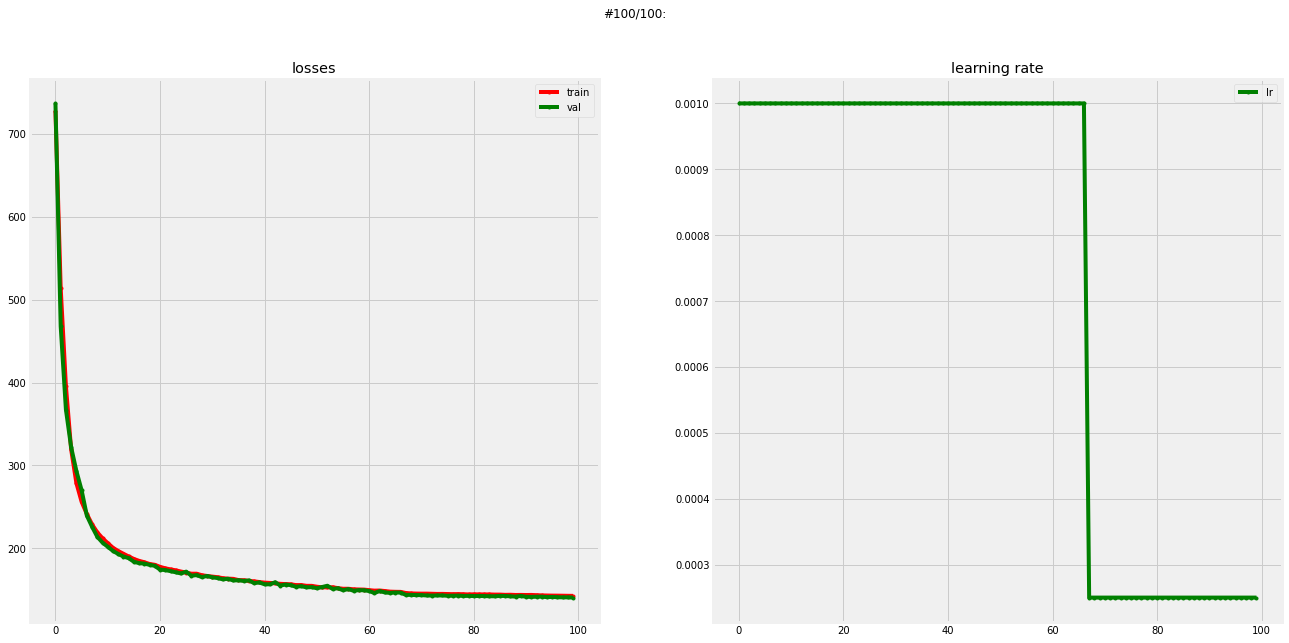

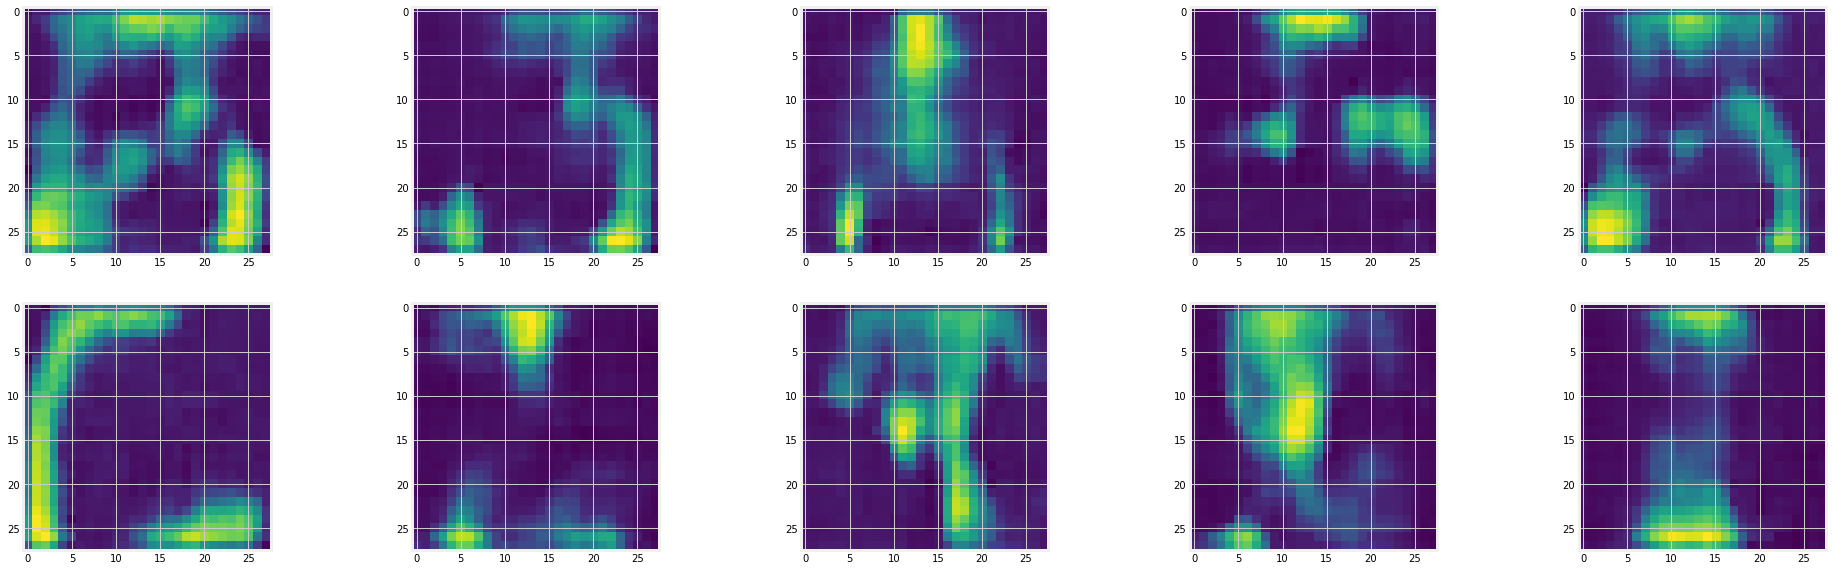

CPU times: user 38min 13s, sys: 31.7 s, total: 38min 45s
Wall time: 38min 8s


In [40]:
%%time

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model, optimizer = create_model_and_optimizer(
    model_class = VAE,
    model_params = dict(hid_size = 16),
    lr = 1e-3,
    device = device,
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=4, threshold=0.001, verbose=True)

criterion = partial(vae_loss, alpha=0.9, show_log=False)

model, optimizer, losses = learning_loop(
    model = model,
    optimizer = optimizer,
    train_loader = train_loader,
    val_loader = val_loader,
    criterion = criterion,
    scheduler = scheduler,
    epochs = 100,
    min_lr = 1e-6,
    val_every = 1,
    draw_every = 10,
    separate_show = False,
    chkp_folder = "./chkp",
    model_name = "test_01",
)

In [44]:
class CustomVAE(nn.Module):
    def __init__(self, hid_size, encoder_params, decoder_params):
        super(CustomVAE, self).__init__()
        
        self.hid_size = hid_size
        self.encoder_params = encoder_params
        self.decoder_params = decoder_params
    
        # 1x28x28 --> 8x14x14 --> 8x7x7 --> 16x3x3 --> 16 --> 32
        self.encoder = Encoder(
            **encoder_params,
        )
        
        # 16x1x1 --> 16x6x6 --> 8x14x14 --> 4x28x28 --> 1x28x28
        self.decoder = Decoder(
            **decoder_params,
        )
        
    def forward(self, x):  # bs x 1 x 28 x 28
        z_stat = self.encoder(x)  # bs x 32
        
        hid_size = z_stat.shape[-1] // 2
        mu = z_stat[:, :hid_size]
        logvar = z_stat[:, hid_size:]
        
        # reparametrization trick  # bs x 16
        z = torch.randn(x.shape[0], hid_size).to(x.device) * torch.exp(logvar / 2.) + mu
        
        x_rec = self.decoder(z[:, :, None, None])
        
        return x_rec, (mu, logvar)

In [50]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

hid_size = 100
results = []

model, optimizer = create_model_and_optimizer(
    model_class = CustomVAE,
    model_params = dict(
        hid_size = 16,
        encoder_params = dict(
            num_blocks=4,
            block_sizes=[3, 3, 3, 3],
            hidden_sizes=[8, 16, 32, 64],
            kernel_sizes=3,
            activation_classes=nn.ReLU,
            use_scales=[True, True, True, True],
            change_sizes=[0, 0, 1, 1],
            dropout_ps=[0., 0., 0.125, 0.25],
            fc_size=hid_size * 2,
        ),
        decoder_params = dict(
            num_blocks=4,
            block_sizes=[3, 3, 3, 3],
            hidden_sizes=[hid_size, 64, 32, 16, 1],
            kernel_sizes=3,
            activation_classes=[nn.ReLU, nn.ReLU, nn.ReLU, nn.Sigmoid],
            use_scales=[True, True, True, False],
            change_sizes=[2, 1, 0, 0],
            dropout_ps=0.,
        ),
    ),
    lr = 1e-3,
    device = device,
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=4, threshold=0.001, verbose=True)

criterion = partial(vae_loss, alpha=0.9, show_log=False)

sum_params, sum_learnable_params = model_num_params(model)

encoder.residual_blocks.residual_0.layers.layer_0.conv.weight     ~  72        params ~ grad: True
encoder.residual_blocks.residual_0.layers.layer_0.bnorm.weight    ~  8         params ~ grad: True
encoder.residual_blocks.residual_0.layers.layer_0.bnorm.bias      ~  8         params ~ grad: True
encoder.residual_blocks.residual_0.layers.layer_1.conv.weight     ~  576       params ~ grad: True
encoder.residual_blocks.residual_0.layers.layer_1.bnorm.weight    ~  8         params ~ grad: True
encoder.residual_blocks.residual_0.layers.layer_1.bnorm.bias      ~  8         params ~ grad: True
encoder.residual_blocks.residual_0.layers.layer_2.conv.weight     ~  576       params ~ grad: True
encoder.residual_blocks.residual_0.layers.layer_2.bnorm.weight    ~  8         params ~ grad: True
encoder.residual_blocks.residual_0.layers.layer_2.bnorm.bias      ~  8         params ~ grad: True
encoder.residual_blocks.residual_0.adapt_residual.weight          ~  8         params ~ grad: True
encoder.re

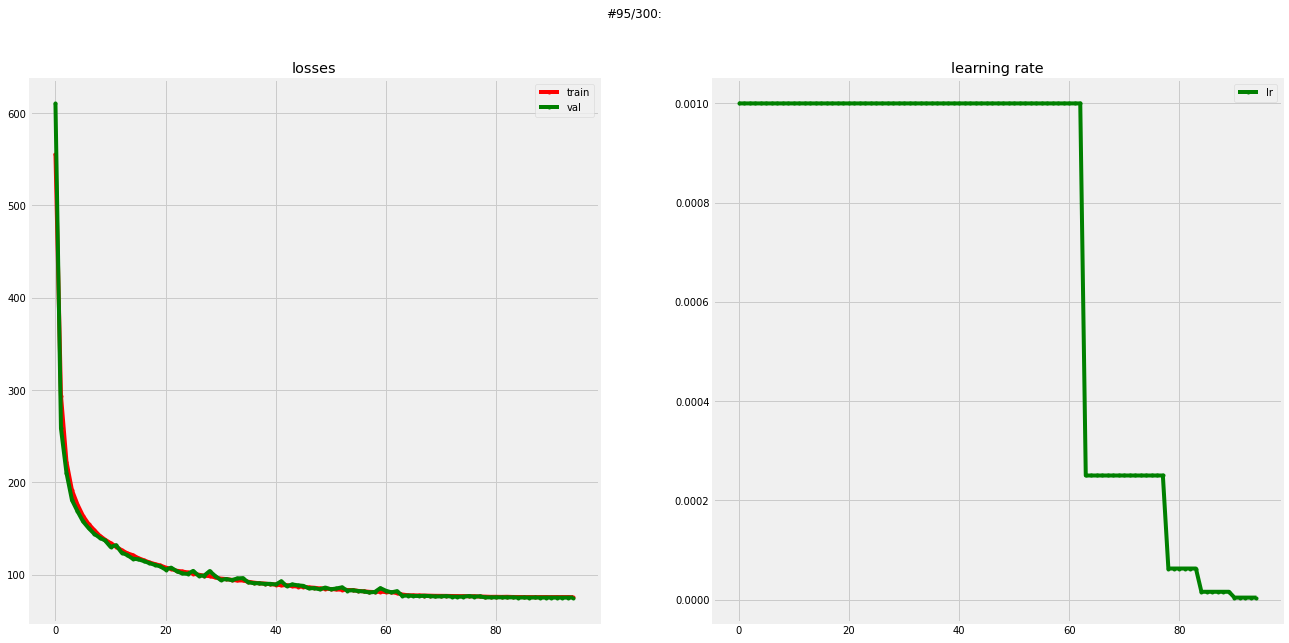

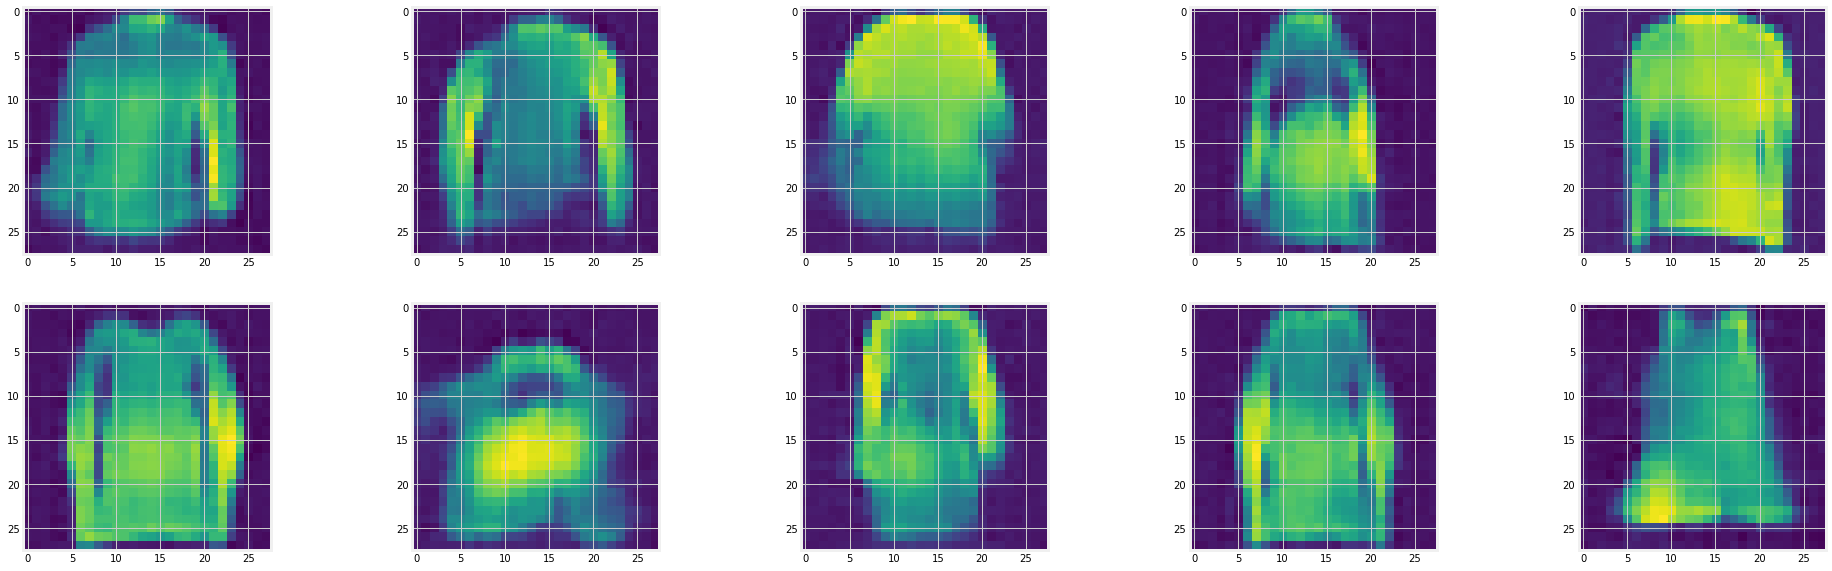

Learning process ended with early stop after epoch 95
CPU times: user 40min 25s, sys: 41 s, total: 41min 6s
Wall time: 40min 23s


In [51]:
%%time
model, optimizer, losses = learning_loop(
    model = model,
    optimizer = optimizer,
    train_loader = train_loader,
    val_loader = val_loader,
    criterion = criterion,
    scheduler = scheduler,
    epochs = 300,
    min_lr = 1e-6,
    val_every = 1,
    draw_every = 1,
    separate_show = False,
    chkp_folder = "./chkp",
    model_name = "test_01",
)

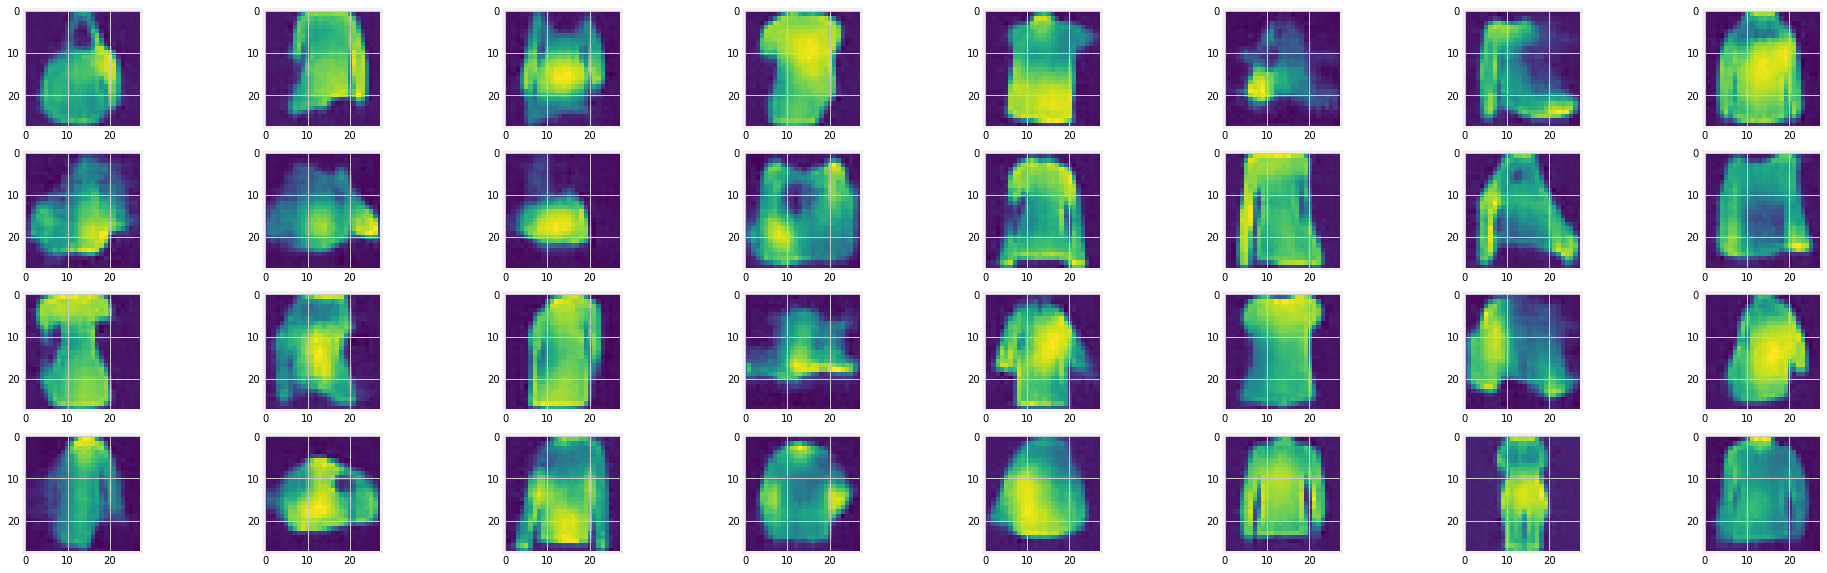

In [55]:
draw_imgs(4, 8)